<a href="https://colab.research.google.com/github/shygnome/sabda-bola/blob/data%2Fpiala-menpora/notebook/Mapping_Indonesia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference:
https://medium.com/analytics-vidhya/mapping-indonesias-village-border-with-plotly-from-long-lat-coordinates-to-wkt-strings-975fd002326e

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd

# For working with geographical data
try:
  import geopanda as gpd
  from geopandas import GeoDataFrame
except:
  !pip install --upgrade geopandas
  import geopandas as gpd
  from geopandas import GeoDataFrame

# For plotting in python
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.graph_objects as go

     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.3 MB 43.5 MB/s 
     |████████████████████████████████| 15.4 MB 60.2 MB/s 


In [2]:
# load downloaded data from github fork, stored in gdrive (1/2)
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
jsonpath_village = "/content/gdrive/MyDrive/geojson/idn_village_geometry.csv"
df = pd.read_csv(jsonpath_village)

# display loaded dataframe
dfx=df[['province','district','sub_district','village','border']].copy()
dfx.head()

,province,district,sub_district,village,border
0,ACEH,ACEH SELATAN,BAKONGAN,KEUDE BAKONGAN,"[[97.4767, 2.9355], [97.4748, 2.9361], [97.471..."
1,ACEH,ACEH SELATAN,BAKONGAN,UJUNG MANGKI,"[[97.4605, 2.9413], [97.4584, 2.9431], [97.457..."
2,ACEH,ACEH SELATAN,BAKONGAN,UJUNG PADANG,"[[97.4767, 2.9355], [97.4835, 2.9333], [97.484..."
3,ACEH,ACEH SELATAN,BAKONGAN,KAMPONG DRIEN,"[[97.5099, 2.9607], [97.505, 2.9648], [97.4942..."
4,ACEH,ACEH SELATAN,BAKONGAN,DARUL IKHSAN,"[[97.4447, 2.9686], [97.4384, 2.9737], [97.425..."


In [4]:
# create dictionary as reference to map polygon & multipolygon values into 
border_dict = dict((k, v) for k,v in enumerate(dfx['border']))

In [5]:
# transform border value from border dictionary into either polygon & multipolygon 
# and replace irregular/non wkt string formattings (i.e inter-bracket commas, etc)
import ast
for k,v in border_dict.items():

  lst = []
  for a in ast.literal_eval(v):
    x = str(a).replace(",","").replace("[","").replace("]",",")
    lst.append(str(x))
  new_dict_polygon = {k:"POLYGON(("+str(lst).replace(",'","").replace("[","").replace("]","").replace("'","")+"))"} 
  new_dict_multipolygon = {k:"MULTIPOLYGON((("+str(lst).replace(",'","").replace("[","").replace("]","").replace("'","").rstrip(',').replace(",,",")),((")+")))"} 
  
  if v.startswith("[[["):
    border_dict.update(new_dict_multipolygon)

  else:
    border_dict.update(new_dict_polygon)  

In [6]:
# map border_dict containing polygon & multipolygon values to original dataframe and name it 'geometry'
dfx['geometry']=dfx.index.map(border_dict)

# see the result and check for specifically multipolygon to confirm if the for loop is working as intended
dfx[dfx.border.str.startswith("[[[")]

,province,district,sub_district,village,border,geometry
9,ACEH,ACEH SELATAN,KLUET UTARA,PASI KUALA ASAHAN,"[[[97.3112, 3.1187], [97.3107, 3.1204], [97.31...","MULTIPOLYGON(((97.3112 3.1187, 97.3107 3.1204,..."
25,ACEH,ACEH SELATAN,KLUET UTARA,KEDAI PADANG,"[[[97.3232, 3.0759], [97.3226, 3.0759], [97.32...","MULTIPOLYGON(((97.3232 3.0759, 97.3226 3.0759,..."
29,ACEH,ACEH SELATAN,KLUET SELATAN,RANTAU BENUANG,"[[[97.3236, 3.0735], [97.3239, 3.0737], [97.32...","MULTIPOLYGON(((97.3236 3.0735, 97.3239 3.0737,..."
46,ACEH,ACEH SELATAN,LABUHAN HAJI,PADANG BAKU,"[[[97.0011, 3.5494], [97.0009, 3.5495], [97.00...","MULTIPOLYGON(((97.0011 3.5494, 97.0009 3.5495,..."
67,ACEH,ACEH SELATAN,MEUKEK,BLANG KUALA,"[[[97.0576, 3.4804], [97.0567, 3.4821], [97.05...","MULTIPOLYGON(((97.0576 3.4804, 97.0567 3.4821,..."
...,...,...,...,...,...,...
83092,PAPUA BARAT,MANOKWARI SELATAN,DATARAN ISIM,ISIM,"[[[134.0574, -1.6649], [134.0273, -1.661], [13...","MULTIPOLYGON(((134.0574 -1.6649, 134.0273 -1.6..."
83282,PAPUA BARAT,KOTA SORONG,SORONG,KLADEMAK,"[[[131.2785, -0.8597], [131.2784, -0.8597], [1...","MULTIPOLYGON(((131.2785 -0.8597, 131.2784 -0.8..."
83293,PAPUA BARAT,KOTA SORONG,SORONG KEPULAUAN,DUM BARAT,"[[[131.2567, -0.9241], [131.2564, -0.9241], [1...","MULTIPOLYGON(((131.2567 -0.9241, 131.2564 -0.9..."
83294,PAPUA BARAT,KOTA SORONG,SORONG KEPULAUAN,DUM TIMUR,"[[[131.2297, -0.9033], [131.2291, -0.9032], [1...","MULTIPOLYGON(((131.2297 -0.9033, 131.2291 -0.9..."


In [7]:
dfx_plot = dfx.copy()

from shapely import wkt
geom = []

for g in dfx_plot['geometry']:
    try:
        geom.append(wkt.loads(g))
    except:
        geom.append(None)

dfx_plot['succeed'] = geom

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1591: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1591: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



In [8]:
from google.colab import files
dfx.to_csv("/content/gdrive/MyDrive/geojson/indoregion_village_mapped.csv")

#Visualize

In [9]:
# define scope of the mapping (i.e DKI JAKARTA)
x = dfx[dfx["province"]=='DKI JAKARTA'][["district","sub_district","village","geometry","border"]].copy()
x = x.astype('string')

# cast geometry column to wkt string geoseries
x['geometry'] = gpd.GeoSeries.from_wkt(x['geometry'])
x = gpd.GeoDataFrame(x)

# create random integer to illustrate use cases
x['pop'] = np.random.randint(0, 3000, x.shape[0])

x.tail()

,district,sub_district,village,geometry,border,pop
25560,JAKARTA TIMUR,CIPAYUNG,MUNJUL,"POLYGON ((106.90320 -6.35230, 106.90320 -6.352...","[[106.9032, -6.3523], [106.9032, -6.3522], [10...",2977
25561,JAKARTA TIMUR,CIPAYUNG,SETU,"POLYGON ((106.91500 -6.30240, 106.91480 -6.302...","[[106.915, -6.3024], [106.9148, -6.3023], [106...",1635
25562,JAKARTA TIMUR,CIPAYUNG,BAMBU APUS,"POLYGON ((106.91480 -6.30230, 106.91470 -6.302...","[[106.9148, -6.3023], [106.9147, -6.3022], [10...",2585
25563,JAKARTA TIMUR,CIPAYUNG,LUBANG BUAYA,"POLYGON ((106.90890 -6.28560, 106.90860 -6.284...","[[106.9089, -6.2856], [106.9086, -6.2844], [10...",169
25564,JAKARTA TIMUR,CIPAYUNG,CEGER,"POLYGON ((106.90600 -6.29960, 106.90580 -6.299...","[[106.906, -6.2996], [106.9058, -6.2996], [106...",885


(106.45347, 106.99753000000003, -6.414395, -5.455304999999999)

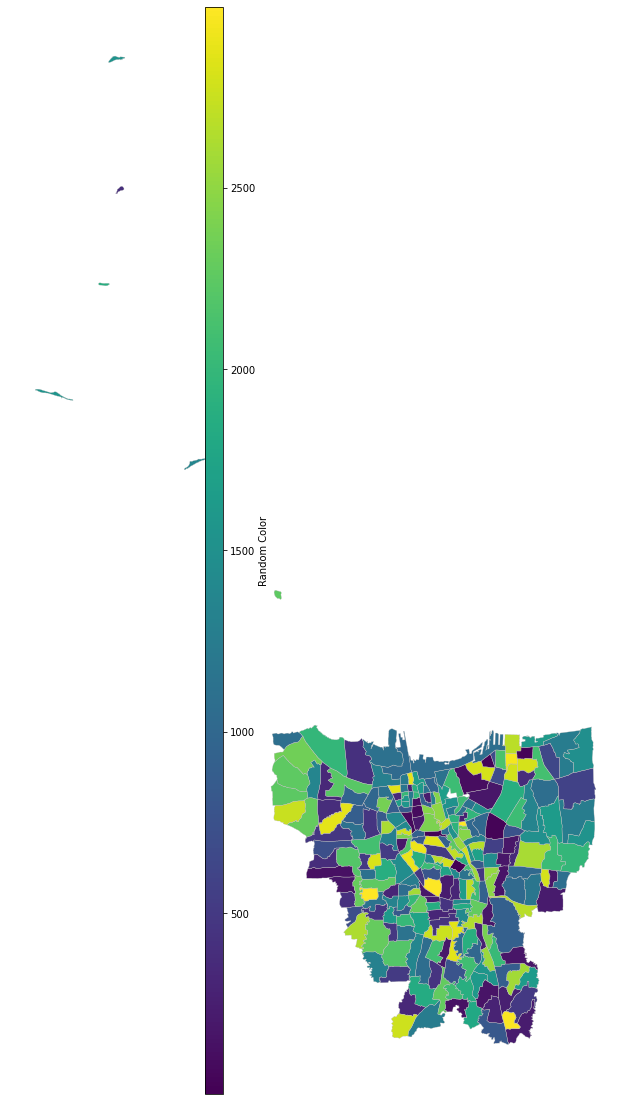

In [10]:

# OPTIONAL: Display using geopandas
fig, ax = plt.subplots(1,1, figsize=(10,20))
divider = make_axes_locatable(ax)
tmpx = x.copy()

#To display values
tmpx['pop'] = tmpx['pop'] 

#resize the colorbar
cax = divider.append_axes("left", size="3%", pad=-3) 
tmpx.plot(column='pop', ax=ax,cax=cax,  legend=True, 
         legend_kwds={'label': "Random Color"})

#Add some borders to the geometries
tmpx.geometry.boundary.plot(color='#BABABA', ax=ax, linewidth=0.3) 
ax.axis('off')

In [14]:
#covert to geoJSON
x_json = x.__geo_interface__ 

# 'INSERT YOUR MAPBOX ACCESS TOKEN HERE'
MAPBOX_ACCESSTOKEN = 'INSERT YOUR MAPBOX ACCESS TOKEN HERE'

zmin = x['pop'].min()
zmax = x['pop'].max()

# Set the data for the map
data = go.Choroplethmapbox(
        geojson = x_json,   #this is your GeoJSON
        locations = x.index,    #the index of this dataframe should align with the 'id' element in your geojson
        z = list(x['pop']), #x.pop, #sets the color value
        text = x.village,    #sets text for each shape
        colorbar=dict(thickness=20, ticklen=3, tickformat='',outlinewidth=0), #adjusts the format of the colorbar
        marker_line_width=1, marker_opacity=0.7, colorscale="Viridis", #adjust format of the plot
        zmin=zmin, zmax=zmax,           #sets min and max of the colorbar
        hovertemplate = "<b>%{text}</b><br>" +
                    "%{z:}<br>" +
                    "<extra></extra>")  # sets the format of the text shown when you hover over each shape

# Set the layout for the map
layout = go.Layout(
    title = {'text': f"Map",
            'font': {'size':24}}, #format the plot title
    mapbox1 = dict(
        domain = {'x': [0, 1],'y': [0, 1]},
        center = dict(lat=-6.174435274770221, lon=106.82538702579708), # change it to reflect your map centre
        accesstoken = MAPBOX_ACCESSTOKEN, 
        zoom = 10),                      
    autosize=True,
    height=750,
    width=1000,

    margin=dict(l=0, r=0, t=40, b=0))

# Generate the map
fig=go.Figure(data=data, layout=layout)
fig.show()